# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
number_of_folds = 7 # this sets global setting of which how many bootstraps to use

lgb_params = {
    'boosting_type': "dart",#'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'max_leaves': 20,
    'max_depth': 3,
    'learning_rate': 0.07,
    'feature_fraction': 0.8,
    'bagging_fraction': 1,
    'min_data_in_leaf': 6,
    'lambda_l1': 0.9,
    'lambda_l2': 0.9,
    "verbose": -1
}

debug_local = True #to use local version

In [2]:
from pathlib import Path
import sys
import inspect

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/opt/miniconda3/envs/yspecies/lib/python38.zip', '/opt/miniconda3/envs/yspecies/lib/python3.8', '/opt/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/opt/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/opt/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/antonkulaga/.ipython']


In [3]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import *
from yspecies.partition import DataPartitioner, FeatureSelection, DataExtractor
from yspecies.selection import ShapSelector, ModelFactory

In [4]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: TkAgg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [6]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [7]:
data = ExpressionDataset.from_folder(locations.interim.selected)
data

## Setting up SHAP selection pipeline ##

Deciding on selection parameters (which fields to include, exclude, predict)

In [8]:
from sklearn.pipeline import Pipeline

selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"])


In [9]:
#mass = selection.replace(to_predict = "mass_g")
#gestation = selection.replace(to_predict = "mass_g")

In [10]:
def prepare_pipeline(selection: FeatureSelection, folds: int = number_of_folds, model_parameters = lgb_params.copy(), seed: int = None, select_by_gain: bool = True) -> Pipeline: 
    params = model_parameters.copy()
    if seed is not None:
        params["seed"] = seed
        params["drop_seed"] = seed        
    return Pipeline([
    ('extractor', DataExtractor(selection)), # to extract the data required for ML from the dataset
    ("partitioner", DataPartitioner(folds = folds, species_in_validation=2, not_validated_species = ["Homo_sapiens"])), # to partition it according to sorted stratification
    ("shap_computation", ShapSelector(ModelFactory(parameters = params), select_by_gain = select_by_gain))] # to train lightGBM and do feature selection
    )

# First stage selection #

## Maximum lifespan ##

In [11]:
lifespan_pipeline = prepare_pipeline(selection)

In [12]:
lifespan_pipeline_shap = prepare_pipeline(selection, select_by_gain = False)

## Instability problem #

In [13]:
#I commented the seed to show how unstable things can be with multiple runs
#SEED = 42
#random.seed(SEED)
#np.random.seed(seed=SEED)

In [14]:
pipe = lifespan_pipeline

In [15]:
results1 = pipe.fit_transform(data)
results1

Early stopping is not available in dart mode
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>gain_score_to_lifespan</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
    <tr>
      <th>ensembl_id</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000083896</th>
      <td>YTHDC1</td>
      <td>1865474.880</td>
      <td>0.149</td>
    </tr>
    <tr>
      <th>ENSG00000167515</th>
      <td>TRAPPC2L</td>
      <td>651815.563</td>
      <td>-0.171</td>
    </tr>
    <tr>
      <th>ENSG00000204590</th>
      <td>GNL1</td>
      <td>600299.521</td>
      <td>0.026</td>
    </tr>
    <tr>
      <th>ENSG00000010219</th>
      <td>DYRK4</td>
      <td>265339.681</td>
      <td>0.362</td>
    </tr>
    <tr>
      <th>ENSG00000105672</th>
      <td>ETV2</td>
      <td>110858.267</td>
      <td>0.693</td>
    </tr>
    <tr>
      <th>ENSG00000106554</th>
      <td>CHCHD3</td>
      <td>92395.890</td>
      <td>-0.380</td>
    </tr>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>85987.224</td>
      <td>0.752</td>
    </tr>
    <tr>
      <th>ENSG00000013288</th>
      <td>MAN2B2</td>
      <td>79028.474</td>
      <td>-0.461</td>
    </tr>
    <tr>
      <th>ENSG00000171121</th>
      <td>KCNMB3</td>
      <td>78984.896</td>
      <td>0.642</td>
    </tr>
    <tr>
      <th>ENSG00000132436</th>
      <td>FIGNL1</td>
      <td>42249.933</td>
      <td>0.539</td>
    </tr>
    <tr>
      <th>ENSG00000066923</th>
      <td>STAG3</td>
      <td>40938.689</td>
      <td>0.491</td>
    </tr>
    <tr>
      <th>ENSG00000157343</th>
      <td>ARMC12</td>
      <td>38492.405</td>
      <td>0.674</td>
    </tr>
    <tr>
      <th>ENSG00000165689</th>
      <td>ENTR1</td>
      <td>24597.507</td>
      <td>-0.721</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>23056.902</td>
      <td>0.720</td>
    </tr>
    <tr>
      <th>ENSG00000129187</th>
      <td>DCTD</td>
      <td>22447.251</td>
      <td>0.732</td>
    </tr>
    <tr>
      <th>ENSG00000136436</th>
      <td>CALCOCO2</td>
      <td>17076.834</td>
      <td>0.727</td>
    </tr>
    <tr>
      <th>ENSG00000164879</th>
      <td>CA3</td>
      <td>16035.102</td>
      <td>-0.479</td>
    </tr>
    <tr>
      <th>ENSG00000178997</th>
      <td>EXD1</td>
      <td>14499.857</td>
      <td>-0.380</td>
    </tr>
    <tr>
      <th>ENSG00000066926</th>
      <td>FECH</td>
      <td>12999.709</td>
      <td>-0.434</td>
    </tr>
    <tr>
      <th>ENSG00000152705</th>
      <td>CATSPER3</td>
      <td>12783.183</td>
      <td>0.770</td>
    </tr>
    <tr>
      <th>ENSG00000180336</th>
      <td>MEIOC</td>
      <td>12484.306</td>
      <td>0.337</td>
    </tr>
    <tr>
      <th>ENSG00000164924</th>
      <td>YWHAZ</td>
      <td>10228.023</td>
      <td>-0.257</td>
    </tr>
    <tr>
      <th>ENSG00000102265</th>
      <td>TIMP1</td>
      <td>6286.499</td>
      <td>0.558</td>
    </tr>
    <tr>
      <th>ENSG00000103275</th>
      <td>UBE2I</td>
      <td>6285.120</td>
      <td>-0.653</td>
    </tr>
    <tr>
      <th>ENSG00000142541</th>
      <td>RPL13A</td>
      <td>5606.047</td>
      <td>-0.215</td>
    </tr>
    <tr>
      <th>ENSG00000108786</th>
      <td>HSD17B1</td>
      <td>5282.247</td>
      <td>0.669</td>
    </tr>
    <tr>
      <th>ENSG00000165501</th>
      <td>LRR1</td>
      <td>4945.289</td>
      <td>0.762</td>
    </tr>
    <tr>
      <th>ENSG00000142002</th>
      <td>DPP9</td>
      <td>4339.570</td>
      <td>-0.727</td>
    </tr>
   

In [26]:
results2 = pipe.fit_transform(data)
results2

<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>gain_score_to_lifespan</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
    <tr>
      <th>ensembl_id</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000083896</th>
      <td>YTHDC1</td>
      <td>1517177.934</td>
      <td>0.131</td>
    </tr>
    <tr>
      <th>ENSG00000167515</th>
      <td>TRAPPC2L</td>
      <td>565839.999</td>
      <td>-0.175</td>
    </tr>
    <tr>
      <th>ENSG00000204590</th>
      <td>GNL1</td>
      <td>386416.696</td>
      <td>0.060</td>
    </tr>
    <tr>
      <th>ENSG00000010219</th>
      <td>DYRK4</td>
      <td>326940.602</td>
      <td>0.470</td>
    </tr>
    <tr>
      <th>ENSG00000171121</th>
      <td>KCNMB3</td>
      <td>104774.357</td>
      <td>0.609</td>
    </tr>
    <tr>
      <th>ENSG00000105672</th>
      <td>ETV2</td>
      <td>99381.969</td>
      <td>0.673</td>
    </tr>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>90408.447</td>
      <td>0.746</td>
    </tr>
    <tr>
      <th>ENSG00000106554</th>
      <td>CHCHD3</td>
      <td>66883.227</td>
      <td>-0.515</td>
    </tr>
    <tr>
      <th>ENSG00000013288</th>
      <td>MAN2B2</td>
      <td>66057.138</td>
      <td>-0.444</td>
    </tr>
    <tr>
      <th>ENSG00000132436</th>
      <td>FIGNL1</td>
      <td>56041.710</td>
      <td>0.555</td>
    </tr>
    <tr>
      <th>ENSG00000157343</th>
      <td>ARMC12</td>
      <td>35180.210</td>
      <td>0.637</td>
    </tr>
    <tr>
      <th>ENSG00000066923</th>
      <td>STAG3</td>
      <td>31345.149</td>
      <td>0.483</td>
    </tr>
    <tr>
      <th>ENSG00000164879</th>
      <td>CA3</td>
      <td>23134.347</td>
      <td>-0.484</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>23132.377</td>
      <td>0.709</td>
    </tr>
    <tr>
      <th>ENSG00000165689</th>
      <td>ENTR1</td>
      <td>17511.054</td>
      <td>-0.758</td>
    </tr>
    <tr>
      <th>ENSG00000129187</th>
      <td>DCTD</td>
      <td>15144.036</td>
      <td>0.701</td>
    </tr>
    <tr>
      <th>ENSG00000178997</th>
      <td>EXD1</td>
      <td>14839.698</td>
      <td>-0.350</td>
    </tr>
    <tr>
      <th>ENSG00000164924</th>
      <td>YWHAZ</td>
      <td>13703.981</td>
      <td>0.009</td>
    </tr>
    <tr>
      <th>ENSG00000006282</th>
      <td>SPATA20</td>
      <td>10263.742</td>
      <td>0.649</td>
    </tr>
    <tr>
      <th>ENSG00000136436</th>
      <td>CALCOCO2</td>
      <td>8942.669</td>
      <td>0.754</td>
    </tr>
    <tr>
      <th>ENSG00000066926</th>
      <td>FECH</td>
      <td>8353.900</td>
      <td>-0.437</td>
    </tr>
    <tr>
      <th>ENSG00000142541</th>
      <td>RPL13A</td>
      <td>6920.707</td>
      <td>-0.250</td>
    </tr>
    <tr>
      <th>ENSG00000152705</th>
      <td>CATSPER3</td>
      <td>5752.290</td>
      <td>0.753</td>
    </tr>
    <tr>
      <th>ENSG00000275489</th>
      <td>C17orf98</td>
      <td>4117.566</td>
      <td>0.506</td>
    </tr>
    <tr>
      <th>ENSG00000096060</th>
      <td>FKBP5</td>
      <td>4033.550</td>
      <td>0.430</td>
    </tr>
    <tr>
      <th>ENSG00000108384</th>
      <td>RAD51C</td>
      <td>4014.047</td>
      <td>0.561</td>
    </tr>
    <tr>
      <th>ENSG00000165501</th>
      <td>LRR1</td>
      <td>3586.321</td>
      <td>0.754</td>
    </tr>
    <tr>
      <th>ENSG00000164362</th>
      <td>TERT</td>
      <td>3535.334</td>
      <td>-0.432</td>
    </tr>
    

In [27]:
results3 = pipe.fit_transform(data)
results3

<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>gain_score_to_lifespan</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
    <tr>
      <th>ensembl_id</th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000083896</th>
      <td>YTHDC1</td>
      <td>1293105.371</td>
      <td>0.161</td>
    </tr>
    <tr>
      <th>ENSG00000167515</th>
      <td>TRAPPC2L</td>
      <td>534214.165</td>
      <td>-0.173</td>
    </tr>
    <tr>
      <th>ENSG00000204590</th>
      <td>GNL1</td>
      <td>307141.952</td>
      <td>-0.069</td>
    </tr>
    <tr>
      <th>ENSG00000010219</th>
      <td>DYRK4</td>
      <td>298138.168</td>
      <td>0.370</td>
    </tr>
    <tr>
      <th>ENSG00000105672</th>
      <td>ETV2</td>
      <td>104611.823</td>
      <td>0.662</td>
    </tr>
    <tr>
      <th>ENSG00000171121</th>
      <td>KCNMB3</td>
      <td>98810.462</td>
      <td>0.646</td>
    </tr>
    <tr>
      <th>ENSG00000170835</th>
      <td>CEL</td>
      <td>94838.996</td>
      <td>0.754</td>
    </tr>
    <tr>
      <th>ENSG00000132436</th>
      <td>FIGNL1</td>
      <td>81989.981</td>
      <td>0.571</td>
    </tr>
    <tr>
      <th>ENSG00000106554</th>
      <td>CHCHD3</td>
      <td>62135.487</td>
      <td>-0.516</td>
    </tr>
    <tr>
      <th>ENSG00000013288</th>
      <td>MAN2B2</td>
      <td>52532.961</td>
      <td>-0.422</td>
    </tr>
    <tr>
      <th>ENSG00000066923</th>
      <td>STAG3</td>
      <td>30436.282</td>
      <td>0.457</td>
    </tr>
    <tr>
      <th>ENSG00000178997</th>
      <td>EXD1</td>
      <td>26812.576</td>
      <td>-0.360</td>
    </tr>
    <tr>
      <th>ENSG00000129187</th>
      <td>DCTD</td>
      <td>24498.719</td>
      <td>0.691</td>
    </tr>
    <tr>
      <th>ENSG00000157343</th>
      <td>ARMC12</td>
      <td>21589.884</td>
      <td>0.660</td>
    </tr>
    <tr>
      <th>ENSG00000165689</th>
      <td>ENTR1</td>
      <td>21336.482</td>
      <td>-0.763</td>
    </tr>
    <tr>
      <th>ENSG00000164879</th>
      <td>CA3</td>
      <td>17814.552</td>
      <td>-0.482</td>
    </tr>
    <tr>
      <th>ENSG00000006282</th>
      <td>SPATA20</td>
      <td>13740.294</td>
      <td>0.669</td>
    </tr>
    <tr>
      <th>ENSG00000152705</th>
      <td>CATSPER3</td>
      <td>12739.049</td>
      <td>0.749</td>
    </tr>
    <tr>
      <th>ENSG00000136436</th>
      <td>CALCOCO2</td>
      <td>11345.829</td>
      <td>0.732</td>
    </tr>
    <tr>
      <th>ENSG00000108786</th>
      <td>HSD17B1</td>
      <td>9872.443</td>
      <td>0.689</td>
    </tr>
    <tr>
      <th>ENSG00000188747</th>
      <td>NOXA1</td>
      <td>8993.977</td>
      <td>0.727</td>
    </tr>
    <tr>
      <th>ENSG00000066926</th>
      <td>FECH</td>
      <td>7821.401</td>
      <td>-0.465</td>
    </tr>
    <tr>
      <th>ENSG00000275489</th>
      <td>C17orf98</td>
      <td>7157.501</td>
      <td>0.501</td>
    </tr>
    <tr>
      <th>ENSG00000142541</th>
      <td>RPL13A</td>
      <td>5240.420</td>
      <td>-0.261</td>
    </tr>
    <tr>
      <th>ENSG00000165501</th>
      <td>LRR1</td>
      <td>3297.165</td>
      <td>0.744</td>
    </tr>
    <tr>
      <th>ENSG00000096060</th>
      <td>FKBP5</td>
      <td>3165.605</td>
      <td>0.353</td>
    </tr>
    <tr>
      <th>ENSG00000023191</th>
      <td>RNH1</td>
      <td>3165.033</td>
      <td>-0.578</td>
    </tr>
    <tr>
      <th>ENSG00000172531</th>
      <td>PPP1CA</td>
      <td>2073.581</td>
      <td>-0.741</td>
    </tr>


## Ploting SHAP values ##

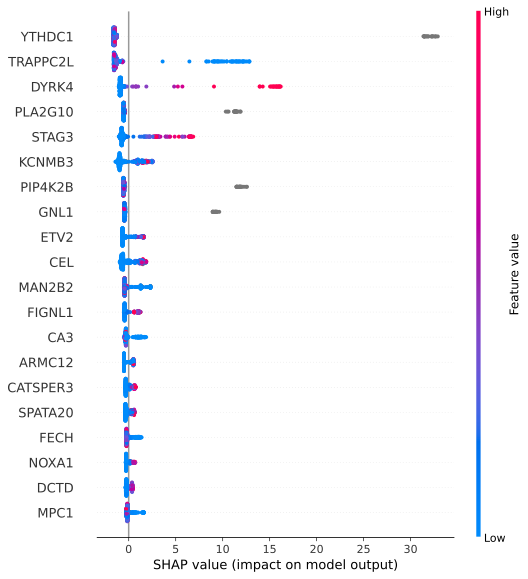

In [18]:
results1.plot(max_display=100)

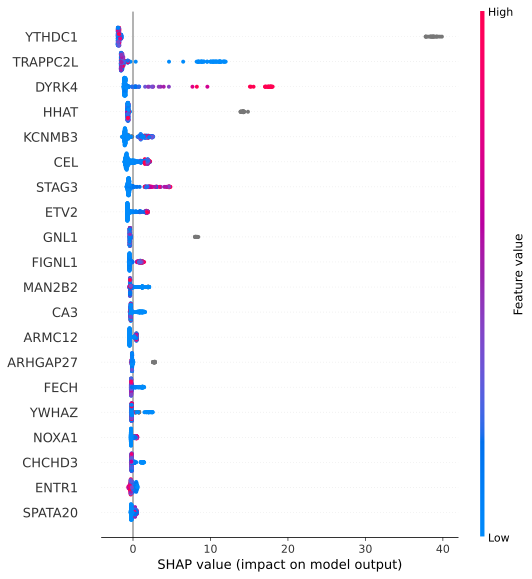

In [19]:
results2.plot(max_display=100)

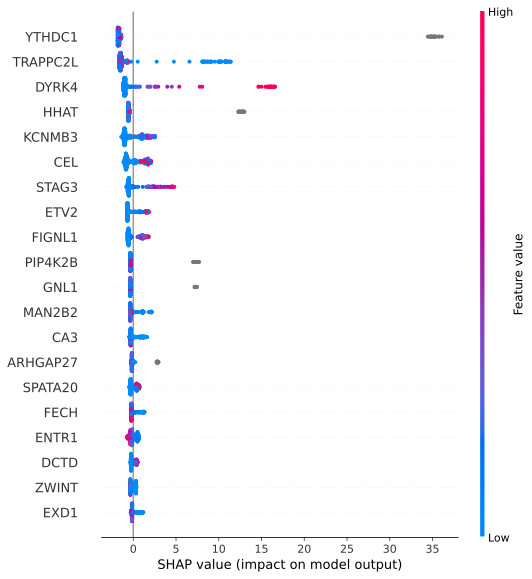

In [20]:
results3.plot(max_display=100)

## Intersections ##

In [21]:
print(results1.selected.shape[0])
print(results2.selected.shape[0])
print(results3.selected.shape[0])

48
38
37


In [22]:
print("genes same in all 3 runs")
results1.selected.index.intersection(results2.selected.index).intersection(results3.selected.index).shape[0]

genes same in all 3 runs


26

## SHAP details display ##

In [18]:
results1.selected_extended

symbol  gain_score_to_lifespan  kendall_tau_to_lifespan  \
ensembl_id                                                                   
ENSG00000083896    YTHDC1             1865474.880                    0.149   
ENSG00000167515  TRAPPC2L              651815.563                   -0.171   
ENSG00000204590      GNL1              600299.521                    0.026   
ENSG00000010219     DYRK4              265339.681                    0.362   
ENSG00000105672      ETV2              110858.267                    0.693   
ENSG00000106554    CHCHD3               92395.890                   -0.380   
ENSG00000170835       CEL               85987.224                    0.752   
ENSG00000013288    MAN2B2               79028.474                   -0.461   
ENSG00000171121    KCNMB3               78984.896                    0.642   
ENSG00000132436    FIGNL1               42249.933                    0.539   
ENSG00000066923     STAG3               40938.689                    0.491   
ENSG00000157343    ARMC12               38492.405                    0.674   
ENSG00000165689     ENTR1               24597.507                   -0.721   
ENSG00000188747     NOXA1               23056.902                    0.720   
ENSG00000129187      DCTD               22447.251                    0.732   
ENSG00000136436  CALCOCO2               17076.834                    0.727   
ENSG00000164879       CA3               16035.102                   -0.479   
ENSG00000178997      EXD1               14499.857                   -0.380   
ENSG00000066926      FECH               12999.709                   -0.434   
ENSG00000152705  CATSPER3               12783.183                    0.770   
ENSG00000180336     MEIOC               12484.306                    0.337   
ENSG00000164924     YWHAZ               10228.023                   -0.257   
ENSG00000102265     TIMP1                6286.499                    0.558   
ENSG00000103275     UBE2I                6285.120                   -0.653   
ENSG00000142541    RPL13A                5606.047                   -0.215   
ENSG00000108786   HSD17B1                5282.247                    0.669   
ENSG00000165501      LRR1                4945.289                    0.762   
ENSG00000142002      DPP9                4339.570                   -0.727   
ENSG00000023191      RNH1                4245.251                   -0.676   
ENSG00000164362      TERT                3227.762                   -0.473   
ENSG00000101166  PRELID3B                2228.675                   -0.604   
ENSG00000122033     MTIF3                1865.457                    0.451   
ENSG00000198663   C6orf89                1359.742                   -0.713   
ENSG00000149089      APIP                1077.288                    0.465   
ENSG00000100764     PSMC1                 410.588                   -0.580   
ENSG00000143994     ABHD1                 195.240                   -0.745   

                 SRR5961830  SRR5885325  SRR306843  SRR306844  SRR306845  \
ensembl_id                                                                 
ENSG00000083896      47.728      47.215     48.772     47.044     47.105   
ENSG00000167515      -0.767      -0.785     -0.787     -0.806     -0.757   
ENSG00000204590      12.878      12.683     13.160     12.756     12.681   
ENSG00000010219      13.293      12.895     13.188      4.387     12.611   
ENSG00000105672       0.048       0.788     -0.301      0.833      0.753   
ENSG00000106554      -0.075      -0.078     -0.055     -0.046     -0.054   
ENSG00000170835       0.737       0.774      0.349      1.337      0.721   
ENSG00000013288      -0.189      -0.170     -0.233     -0.159     -0.170   
ENSG00000171121       0.931       0.995     -0.580      1.031      1.026   
ENSG00000132436       0.599      -0.129      0.592      0.597      0.553   
ENSG00000066923       5.670       5.555      5.349      5.576      5.554   
ENSG00000157343       0.215       0.214      0.217      0.226     

## per gene ##

In [74]:
show(results1.partitions.X,10,10)

ensembl_id  ENSG00000139990  ENSG00000073921  ENSG00000139687  \
run                                                             
SRR5961830           26.655          465.005           55.082   
SRR5885325           10.578           95.720            7.969   
SRR306843            11.918           78.732            1.167   
SRR306844            18.714           47.023           13.521   
SRR306845            16.423           61.764           15.757   
SRR306841            12.673           84.034           12.452   
SRR306840            16.837           99.109           14.010   
SRR306839            12.512          104.142            5.173   
SRR787277            26.026          575.293          104.400   
SRR1521445           11.921           78.535           10.850   

ensembl_id  ENSG00000119977  ENSG00000242866  ENSG00000135506  \
run                                                             
SRR5961830           13.343            3.845           86.345   
SRR5885325           17.294            0.165           92.622   
SRR306843             4.372            2.623           71.952   
SRR306844             4.307           21.699          254.783   
SRR306845            11.516           25.387          152.155   
SRR306841            13.777            2.591           87.754   
SRR306840            12.868           11.620           84.165   
SRR306839             7.631            4.599           92.039   
SRR787277            10.912            0.199          123.212   
SRR1521445           10.162            8.670          100.439   

ensembl_id  ENSG00000162426  ENSG00000165995  ENSG00000073756  ENSG00000138050  
run                                                                             
SRR5961830            7.693          137.115           13.902           52.017  
SRR5885325            1.908            3.058            4.627            4.955  
SRR306843            13.427           25.618            4.684            1.508  
SRR306844             7.247           15.522            0.705           11.868  
SRR306845            18.972           23.108            1.287           12.192  
SRR306841             9.910           31.474            1.816            7.506  
SRR306840            15.426           37.553            3.502            9.418  
SRR306839            20.007           29.659            2.401            3.781  
SRR787277             0.146           42.191           82.374           40.371  
SRR1521445           11.340           22.534            2.425           20.061

In [109]:
show(results1.gene_details("YTHDC1", data.samples),100,10)

general info: run
symbol                         YTHDC1
gain_score_to_lifespan    1865474.880
kendall_tau_to_lifespan         0.149
Name: ENSG00000083896, dtype: object


expressions shap_values   bioproject  \
run                                               
SRR5961830         NaN      47.728  PRJNA398031   
SRR5885325         NaN      47.215  PRJNA396588   
SRR306843          NaN      48.772  PRJNA143627   
SRR306844          NaN      47.044  PRJNA143627   
SRR306845          NaN      47.105  PRJNA143627   
SRR306841          NaN      47.437  PRJNA143627   
SRR306840          NaN      46.827  PRJNA143627   
SRR306839          NaN      47.790  PRJNA143627   
SRR787277          NaN      48.106  PRJNA193501   
SRR1521445         NaN      47.431  PRJNA255754   

                                              series       species  tissue  \
run                                                                          
SRR5961830                               PRJNA398031  Homo_sapiens   Brain   
SRR5885325  geo/query/acc.cgi?acc=GSE86095_GSE102101  Homo_sapiens  Kidney   
SRR306843             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306844             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306845             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306841             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306840             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR306839             geo/query/acc.cgi?acc=GSE30352  Homo_sapiens   Brain   
SRR787277             geo/query/acc.cgi?acc=GSE45326  Homo_sapiens    Lung   
SRR1521445            geo/query/acc.cgi?acc=GSE59612  Homo_sapiens   Brain   

           sample_name                                    characteristics  \
run                                                                         
SRR5961830  GSM2740643  no;no;5.7;no;72;17;Orbitofrontal (OFC; BA11);y...   
SRR5885325  GSM2723925  no;adjacent normal kidney;patient 40911432;adj...   
SRR306843    GSM752696  Brain, temporal lobe;male;8.1;Commercial / AMS...   
SRR306844    GSM752697  Cerebellum;female;8.5;Commercial / AMS biotech...   
SRR306845    GSM752698         Cerebellum;male;8.9;Commercial / Ambion;no   
SRR306841    GSM752694  Brain, prefrontal cortex;male;8.5;Netherland B...   
SRR306840    GSM752693  Brain, prefrontal cortex;male;8.6;Netherland B...   
SRR306839    GSM752692  Brain, frontal cortex;male;8.8;Commercial / Am...   
SRR787277   GSM1101973                       Biochain:R-1234152-P;lung;no   
SRR1521445  GSM1440503  non-neoplastic brain tissue;non-neoplastic bra...   

                               sequencer  age     sex tumor  \
run                                                           
SRR5961830           Illumina_HiSeq_2000   72  female    no   
SRR5885325           Illumina_HiSeq_2000  NaN     NaN    no   
SRR306843   Illumina_Genome_Analyzer_IIx  NaN    male    no   
SRR306844   Illumina_Genome_Analyzer_IIx  NaN  female    no   
SRR306845   Illumina_Genome_Analyzer_IIx  NaN    male    no   
SRR306841   Illumina_Genome_Analyzer_IIx  NaN    male    no   
SRR306840   Illumina_Genome_Analyzer_IIx  NaN    male    no   
SRR306839   Illumina_Genome_Analyzer_IIx  NaN    male    no   
SRR787277            Illumina_HiSeq_2000  NaN     NaN    no   
SRR1521445           Illumina_HiSeq_2000  NaN     NaN    no   

                                 source  \
run                                       
SRR5961830    Orbitofrontal (OFC; BA11)   
SRR5885325       adjacent normal kidney   
SRR306843          Brain, temporal lobe   
SRR306844                    Cerebellum   
SRR306845                    Cerebellum   
SRR306841      Brain, prefrontal cortex   
SRR306840      Brain, prefrontal cortex   
SRR306839         Brain, frontal cortex   
SRR787277                          lung   
SRR1521445  non-neoplastic brain tissue   

                                                        study  \
run                                                             
SRR5961830  https://trace.ncbi.nlm.nih.gov/Traces/sra/?stu...   
SRR5885325  https://trace.ncbi.nlm.nih.gov/Traces/sra/?stu...   
SR

In [92]:
show(results1.partitions.X_T,100,10)

run              SRR5961830  SRR5885325  SRR306843  SRR306844  SRR306845  \
ensembl_id                                                                 
ENSG00000139990      26.655      10.578     11.918     18.714     16.423   
ENSG00000073921     465.005      95.720     78.732     47.023     61.764   
ENSG00000139687      55.082       7.969      1.167     13.521     15.757   
ENSG00000119977      13.343      17.294      4.372      4.307     11.516   
ENSG00000242866       3.845       0.165      2.623     21.699     25.387   
ENSG00000135506      86.345      92.622     71.952    254.783    152.155   
ENSG00000162426       7.693       1.908     13.427      7.247     18.972   
ENSG00000165995     137.115       3.058     25.618     15.522     23.108   
ENSG00000073756      13.902       4.627      4.684      0.705      1.287   
ENSG00000138050      52.017       4.955      1.508     11.868     12.192   

run              SRR306841  SRR306840  SRR306839  SRR787277  SRR1521445  \
ensembl_id                                                                
ENSG00000139990     12.673     16.837     12.512     26.026      11.921   
ENSG00000073921     84.034     99.109    104.142    575.293      78.535   
ENSG00000139687     12.452     14.010      5.173    104.400      10.850   
ENSG00000119977     13.777     12.868      7.631     10.912      10.162   
ENSG00000242866      2.591     11.620      4.599      0.199       8.670   
ENSG00000135506     87.754     84.165     92.039    123.212     100.439   
ENSG00000162426      9.910     15.426     20.007      0.146      11.340   
ENSG00000165995     31.474     37.553     29.659     42.191      22.534   
ENSG00000073756      1.816      3.502      2.401     82.374       2.425   
ENSG00000138050      7.506      9.418      3.781     40.371      20.061   

run              SRR3715877  SRR5008362  SRR5120939  SRR5120940  SRR8702484  \
ensembl_id                                                                    
ENSG00000139990      45.730       4.765      37.904      33.205       5.864   
ENSG00000073921     229.144      51.601     124.517     113.369      23.870   
ENSG00000139687      49.916       8.809      27.603      21.872       2.812   
ENSG00000119977      18.979       2.429      24.449      20.109       6.136   
ENSG00000242866       1.852       0.007       0.070       0.058       0.671   
ENSG00000135506     149.272      39.848     172.862     166.215     116.041   
ENSG00000162426       1.462       0.195       1.138       0.758       0.552   
ENSG00000165995      19.608       5.933       2.437       3.179       0.188   
ENSG00000073756      17.951       0.077      54.820      14.629       0.625   
ENSG00000138050      10.179      25.693      12.161       9.393       2.050   

run              SRR5961972  SRR5961875  SRR306842  SRR306809  SRR306808  \
ensembl_id                                                                 
ENSG00000139990      29.373      20.683     15.001      4.824      7.661   
ENSG00000073921     532.382     645.336    232.882     21.910     22.375   
ENSG00000139687      54.231      56.189     11.376      1.864      2.895   
ENSG00000119977      12.200      10.597      5.570      2.469      1.869   
ENSG00000242866       4.271       1.484      3.475      0.074      0.000   
ENSG00000135506     100.576     116.249     76.628     57.249     82.848   
ENSG00000162426       8.889       5.227      8.035      0.306      0.060   
ENSG00000165995     132.921      87.490      2.472      4.065      3.271   
ENSG00000073756      23.412       7.386      0.343      1.704      0.527   
ENSG00000138050      29.121      25.597      7.701      1.358      1.758   

run              SRR306801  SRR649365  SRR306807  SRR306806  SRR306805  \
ensembl_id                                                               
ENSG00000139990     15.276      7.107      5.804     14.138      1.886   
ENSG00000073921     71.118     67.606     60.521     92.480      5.893   
ENSG00000139687      8.574  